In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils import data

# Import moving MNIST

In [2]:
Moving_MNIST = np.load('data/mnist_test_seq.npy')
Moving_MNIST = Moving_MNIST / 255
Moving_MNIST.shape

(20, 10000, 64, 64)

# Give `torch` the data

In [3]:
# Making into PyTorch tensor
Moving_MNIST_tensor = torch.from_numpy(Moving_MNIST)

# Putting the existing dimensions into appropriate order
Moving_MNIST_tensor = Moving_MNIST_tensor.permute(1, 0, 2, 3)

# Added the acknowledge that this is 1 spectral band
Moving_MNIST_tensor = Moving_MNIST_tensor.unsqueeze(2)

# Checking shape
Moving_MNIST_tensor.shape

torch.Size([10000, 20, 1, 64, 64])

# Train/validation split

In [4]:
train_indices = np.random.choice(range(10000), size = 8000, replace = False)

OutofSample_indices = [index for index in range(10000) if index not in train_indices.tolist()]
validation_indices = np.random.choice(OutofSample_indices, size = 1000, replace = False)

# Separating $x$ (first $10$ in each sequence) and $y$ (last $10$ in each sequence)

In [5]:
def sep_x_y(tensor_to_separate):
    x = []
    y = []
    for i in range(len(tensor_to_separate)):
        current_seq = tensor_to_separate[i, :, :, :, :]
        for j in range(current_seq.shape[0]):
            if j >= 10:
                current_x = current_seq[(j-10):j].numpy()
                x.append(current_x)
                current_y = current_seq[j].unsqueeze(dim = 0).numpy()
                y.append(current_y)
    x = np.asarray(x)
    x = torch.from_numpy(x).type(torch.FloatTensor)
    y = np.asarray(y)
    y = torch.from_numpy(y).type(torch.FloatTensor)
    return(x, y)

In [6]:
x, y = sep_x_y(Moving_MNIST_tensor[train_indices])
x_validation, y_validation = sep_x_y(Moving_MNIST_tensor[validation_indices])

# Viewing the overlaid $(x, y)$ sequences

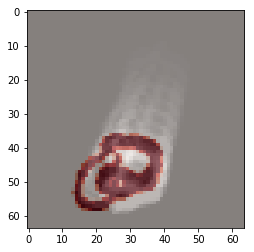

In [7]:
random_index = np.random.choice(len(x_validation))

for i in range(10):
    plt.imshow(x_validation[random_index, i, 0], alpha = 0.25, cmap = 'gist_gray')
plt.imshow(y_validation[random_index, 0, 0], cmap = 'Reds', alpha = 0.5);

# Defining the model

In [8]:
class ConvTime_LSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias, GPU):
        """
        Initialize ConvTime_LSTM cell.
        
        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvTime_LSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias        = bias
        self.GPU         = GPU
        
        ## Defining the input convolutional layer ##
        self.i_conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                                out_channels=self.hidden_dim,
                                kernel_size=self.kernel_size,
                                padding=self.padding,
                                bias=self.bias)
        
        ## Defining the T2 convolutional layer ##
        self.T1_conv = nn.Conv2d(in_channels=self.input_dim,
                                 out_channels=self.hidden_dim,
                                 kernel_size=self.kernel_size,
                                 padding=self.padding,
                                 bias=self.bias)
        
        ## Defining the T1 convolutional layer ##
        self.T2_conv = nn.Conv2d(in_channels=self.input_dim,
                                 out_channels=self.hidden_dim,
                                 kernel_size=self.kernel_size,
                                 padding=self.padding,
                                 bias=self.bias)
        
        ## Defining the activation convolutional layer ##
        self.c_conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                                out_channels=self.hidden_dim,
                                kernel_size=self.kernel_size,
                                padding=self.padding,
                                bias=self.bias)
        
        ## Defining the output convolutional layer ##
        self.o_conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                                out_channels=self.hidden_dim,
                                kernel_size=self.kernel_size,
                                padding=self.padding,
                                bias=self.bias)
        
        ## Defining the learnable parameter for time scaling ##
        self.constrained_scalar = nn.Parameter(torch.rand(1, 1))
        self.unconstrained_scalars = nn.Parameter(torch.rand(2, 1))

    def forward(self, input_tensor, time_tensor, cur_state):
        
        
        ## Getting the h_{m-1} and c_{m-1} ##
        ##     the previous hidden and activations ##
        h_cur, c_cur = cur_state
        
        
        ## Getting the (time tensor)*(their learned scalar) ##
        ## For T1, with a constrained weight ##
        t_T1 = self.constrained_scalar.clamp(max = 0) * time_tensor
        ## For T2 and output gate, without constraints ##
        t_bands_list = []
        for i in range(2):
            unconstrained_scalar = self.unconstrained_scalars[i]
            scaled_time_tensors = time_tensor * unconstrained_scalar
            t_bands_list.append(scaled_time_tensors)
        t_T2, t_o = t_bands_list
        ## Applying the appropriate non-linearities to t_T1 and t_T2 ##
        t_T1 = torch.sigmoid(t_T1)
        t_T2 = torch.sigmoid(t_T2)


        ## concatenate the prev. hidden state and the current input along the color channel dim ##
        x_h_combined = torch.cat([input_tensor, h_cur], dim = 1)
        
        
        ## The input gate ##
        ## Running the input convolution ##
        i_conv_outputs = self.i_conv(x_h_combined)
        ## Running the input LSTM gate equations ##
        i_m = torch.sigmoid(i_conv_outputs)
        
        
        ## The first time gate ##
        ## Running the first time convolution ##
        T1_conv_outputs = self.T1_conv(input_tensor)
        T1_conv_outputs = T1_conv_outputs + t_T1
        ## Running the T1 LSTM gate equations ##
        T1_m = torch.sigmoid(T1_conv_outputs)
        
        
        ## The second time gate ##
        ## Running the second time convolution ##
        T2_conv_outputs = self.T2_conv(input_tensor)
        T2_conv_outputs = T2_conv_outputs + t_T2
        ## Running the T2 LSTM gate equations ##
        T2_m = torch.sigmoid(T2_conv_outputs)
        
        
        ## The c vectors ##
        ## Running the c convolution ##
        c_conv_outputs = self.c_conv(x_h_combined)
        ## Computing the c tilde and c activation vectors ##
        c_m_tilde = (((1 - i_m * T1_m) * c_cur) +
                     (i_m * T1_m * torch.tanh(c_conv_outputs)))
        c_m = (((1 - i_m) * c_cur) +
               (i_m * T2_m * torch.tanh(c_conv_outputs)))
        
         
        ## The output gate ##
        ## Running the output gate convolution
        o_conv_output = self.o_conv(x_h_combined)
        o_conv_output = o_conv_output + t_o
        ## Running the output LSTM gate equations
        o_m = torch.sigmoid(o_conv_output)
        
        
        ## The hidden vector ##
        h_m = o_m * torch.tanh(c_m_tilde)
        
        
        return h_m, c_m

    def init_hidden(self, batch_size):
        to_return = (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)),
                     Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)))
        if self.GPU:
            to_return = (to_return[0].cuda(), to_return[1].cuda())
        return(to_return)


class ConvTime_LSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first, bias, return_all_layers, GPU):
        super(ConvTime_LSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.GPU = GPU

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvTime_LSTMCell(input_size=(self.height, self.width),
                                               input_dim=cur_input_dim,
                                               hidden_dim=self.hidden_dim[i],
                                               kernel_size=self.kernel_size[i],
                                               bias=self.bias,
                                               GPU=self.GPU))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, time_tensor, hidden_state=None):
        """
        
        Parameters
        ----------
        input_tensor: todo 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
            
        Returns
        -------
        last_state_list, layer_output
        """
        
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor
        cur_time_input = time_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor = cur_layer_input[:, t, :, :, :],
                                                 time_tensor = cur_time_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [9]:
# Picking one of the like-sequence tensors within the list to set parameters
channels = x.shape[2]
height = x.shape[3]
width = x.shape[4]

In [10]:
conv_time_lstm = ConvTime_LSTM(input_size = (height,
                                             width),
                               input_dim = channels,
                               hidden_dim = [128, 64, 64, 1],
                               kernel_size = (5, 5),
                               num_layers = 4,
                               batch_first = True,
                               bias = True,
                               return_all_layers = False,
                               GPU = True)

In [11]:
conv_time_lstm.cuda()

ConvTime_LSTM(
  (cell_list): ModuleList(
    (0): ConvTime_LSTMCell(
      (i_conv): Conv2d(129, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T1_conv): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T2_conv): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (c_conv): Conv2d(129, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (o_conv): Conv2d(129, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvTime_LSTMCell(
      (i_conv): Conv2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T1_conv): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T2_conv): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (c_conv): Conv2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (o_conv): Conv2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (2): ConvTime_LSTMCell(
      (i_conv): Conv2d(128,

# Training

In [12]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(conv_time_lstm.parameters())

In [13]:
class train_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x[IDs, :, :, :, :]
        curr_y = y[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_y)
    
class validation_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x_validation[IDs, :, :, :, :]
        curr_y = y_validation[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_y)

In [14]:
training_set = train_Dataset(data_indices=range(y.shape[0]))
validation_set = validation_Dataset(data_indices=range(y_validation.shape[0]))

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset = training_set,
                                           batch_size = batch_size,
                                           shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_set,
                                                batch_size = batch_size,
                                                shuffle = True)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
conv_time_lstm = torch.nn.DataParallel(conv_time_lstm)

In [17]:
loss_list = []
epochs = int(np.ceil((7*10**5) / x.shape[0]))
for i in range(epochs):
    for data in train_loader:
        
        # data loader
        batch_x, batch_y = data
        
        # move to GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # run model and get the prediction
        batch_y_hat = conv_time_lstm(batch_x,
                                     torch.ones_like(batch_x))
        batch_y_hat = batch_y_hat[0][0][:, -2:-1, :, :, :]
        
        # calculate and store the loss
        batch_loss = loss(batch_y, batch_y_hat)
        loss_list.append(batch_loss.item())
        
        # update parameters
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    print('Epoch: ', i, '\n\tBatch loss: ', batch_loss.item(), '\n')

Epoch:  0 
	Batch loss:  0.016040362417697906 

Epoch:  1 
	Batch loss:  0.015307961031794548 

Epoch:  2 
	Batch loss:  0.011756250634789467 

Epoch:  3 
	Batch loss:  0.012823062017560005 

Epoch:  4 
	Batch loss:  0.011319277808070183 

Epoch:  5 
	Batch loss:  0.011674477718770504 

Epoch:  6 
	Batch loss:  0.01063500251621008 

Epoch:  7 
	Batch loss:  0.009473486803472042 

Epoch:  8 
	Batch loss:  0.009690665639936924 



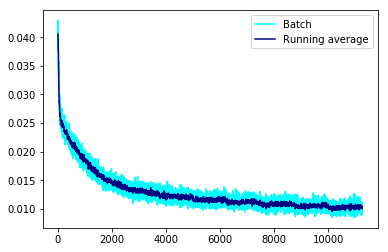

In [18]:
plt.plot(loss_list,
         color = 'cyan',
         label = 'Batch')
plt.plot(np.convolve(loss_list, 1/10*np.ones(10))[10:-10],
         color = 'navy',
         label = 'Running average')
plt.legend();

# Getting random predictions for the validation set

In [19]:
rand_x, rand_y = next(iter(validation_loader))

rand_y_hat = conv_time_lstm(rand_x.to(device),
                            torch.ones_like(rand_x).to(device))[0][0][:, -2:-1, :, :, :]
rand_y_hat = rand_y_hat.cpu().data.numpy()

# Viewing random predictions for the validation set

In [20]:
def plot_random_validation_pred():
    f, axarr = plt.subplots(1, 2)
    f.set_figheight(4)
    f.set_figwidth(8)
    random_index = np.random.choice(len(rand_x))
    for i in range(10):
        axarr[0].imshow(rand_x[random_index, i, 0], alpha = 0.25, cmap = 'gist_gray')
        axarr[1].imshow(rand_x[random_index, i, 0], alpha = 0.25, cmap = 'gist_gray')
    axarr[0].imshow(rand_y[random_index, 0, 0], cmap = 'Reds', alpha = 0.5)
    axarr[0].set_title('Red = True', fontsize = 15)
    axarr[1].imshow(rand_y_hat[random_index, 0, 0], cmap = 'Greens', alpha = 0.5)
    axarr[1].set_title('Green = Predicted', fontsize = 15);

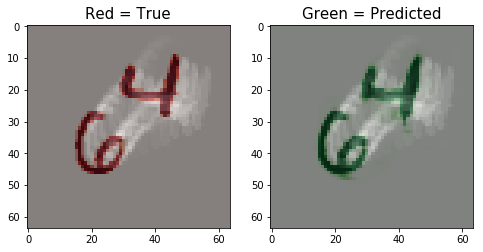

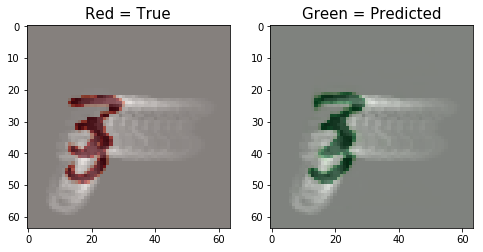

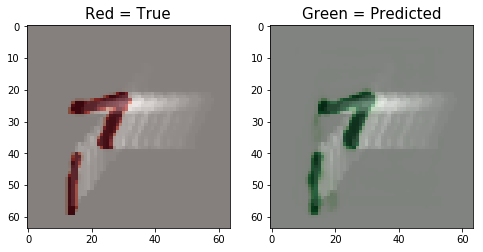

In [21]:
plot_random_validation_pred()
plot_random_validation_pred()
plot_random_validation_pred()

In [22]:
def overlay_pred_true():
    random_index = np.random.choice(len(rand_x))
    plt.imshow(rand_y[random_index, 0, 0], cmap = 'Reds', alpha = 0.5)
    plt.imshow(rand_y_hat[random_index, 0, 0], cmap = 'Greens', alpha = 0.5)

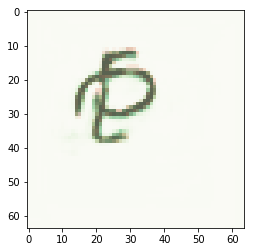

In [23]:
overlay_pred_true()

# Mimicking sequence-to-sequence by shuffling in predictions

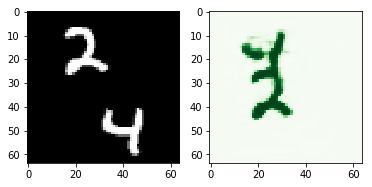

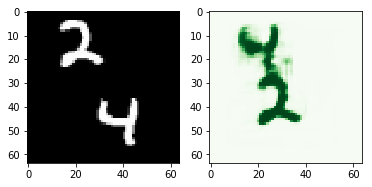

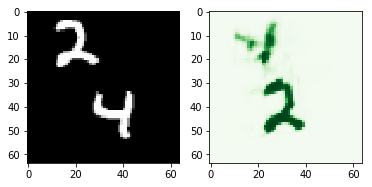

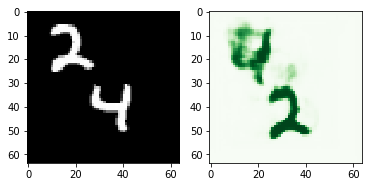

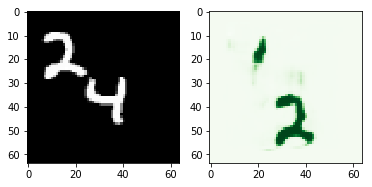

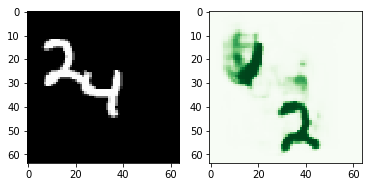

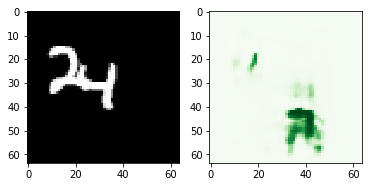

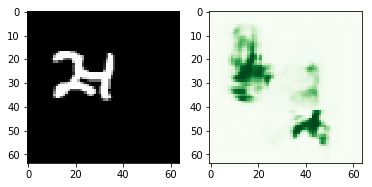

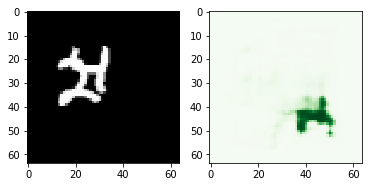

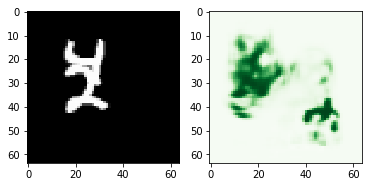

In [24]:
random_index = np.random.choice(len(rand_x) - 1)
rand_x = rand_x[random_index:(random_index+1)]

for i in range(10):
    f, axarr = plt.subplots(1, 2)
    f.set_figheight(3)
    f.set_figwidth(6)
    axarr[0].imshow(rand_x[0, 0, 0], cmap = 'gist_gray')
    rand_y_hat = conv_time_lstm(rand_x.to(device),
                                torch.ones_like(rand_x.to(device)))[0][0][:, -2:-1, :, :, :]
    axarr[1].imshow(rand_y_hat[0, 0, 0].data.cpu().numpy(), cmap = 'Greens')
    rand_x = torch.cat([rand_x, rand_y_hat.data.cpu()], dim = 1)
    rand_x = rand_x[:, 1:]
    plt.pause(0.01)

# Saving the model weights for transfer learning to MissingMNIST

In [25]:
torch.save(conv_time_lstm, 'ConvTimeLSTMSavedModel')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvTime_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvTime_LSTMCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
